**Mengoneksikan BigQuery Ke Colab**

In [40]:
# Meng-install dan import library BigQuery
!pip install --upgrade google-cloud-bigquery

# Login ke akun Google
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

project_id = "retail-churn-project"

# Membuat client BigQuery
client = bigquery.Client(project=project_id)

# Menulis query
query = """
select
  Customer_ID,
  Product,
  date(timestamp_seconds(cast(First_Transaction / 1000 as int64))) as First_Transaction_Date,
  date(timestamp_seconds(cast(Last_Transaction / 1000 as int64))) as Last_Transaction_Date,
  Average_Transaction_Amount,
  Count_Transaction,

--Menambah kolom 'Total_Amount'
  Average_Transaction_Amount * Count_Transaction as Total_Amount,

--Menambah kolom 'is_churn': True jika Last_Transaction sebelum 1 Agustus 2018
case
  when date(timestamp_seconds(cast(Last_Transaction / 1000 as int64))) < date('2018-08-01') then true
  else false
end as is_churn
from `retail_dataset.data_retail`;
"""
# Mengeksekusi query ke dalam dataframe
df = client.query(query).to_dataframe()

# Mengecek 5 data teratas
df.head()

,Customer_ID,Product,First_Transaction_Date,Last_Transaction_Date,Average_Transaction_Amount,Count_Transaction,Total_Amount,is_churn
0,350761,Baju,2018-12-24,2018-12-24,1575580,1,1575580,False
1,25436,Baju,2018-06-07,2018-06-07,1027351,1,1027351,True
2,53474,Baju,2018-06-03,2018-06-03,908294,1,908294,True
3,124590,Baju,2018-11-25,2018-11-25,890890,1,890890,False
4,43830,Baju,2018-07-11,2018-07-11,2817561,1,2817561,True


**Mengonversi Data Ke Dalam Bentuk CSV**

In [41]:
# Menyimpan ke file CSV
df.to_csv('df.csv', index=False)

# Mengecek tipe data dan missing values
df.info()

# Statistik deskriptif numerik
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Customer_ID                 100000 non-null  Int64  
 1   Product                     100000 non-null  object 
 2   First_Transaction_Date      100000 non-null  dbdate 
 3   Last_Transaction_Date       100000 non-null  dbdate 
 4   Average_Transaction_Amount  100000 non-null  Int64  
 5   Count_Transaction           100000 non-null  Int64  
 6   Total_Amount                100000 non-null  Int64  
 7   is_churn                    100000 non-null  boolean
dtypes: Int64(4), boolean(1), dbdate(2), object(1)
memory usage: 5.9+ MB


,Customer_ID,Average_Transaction_Amount,Count_Transaction,Total_Amount
count,100000.0,100000.0,100000.0,100000.0
mean,193083.99694,1373157.358,11.6985,16404237.30386
std,200747.292955,1544434.671051,35.417324,62896260.950393
min,654.0,0.0,1.0,0.0
25%,60994.5,478303.75,1.0,718321.75
50%,121441.0,905937.0,2.0,1852243.0
75%,196023.0,1636371.5,6.0,8506847.5
max,846213.0,48810144.0,3852.0,7780489164.0


**The Outlier of Average Transaction Amount, Count Transaction, and Total Amount**

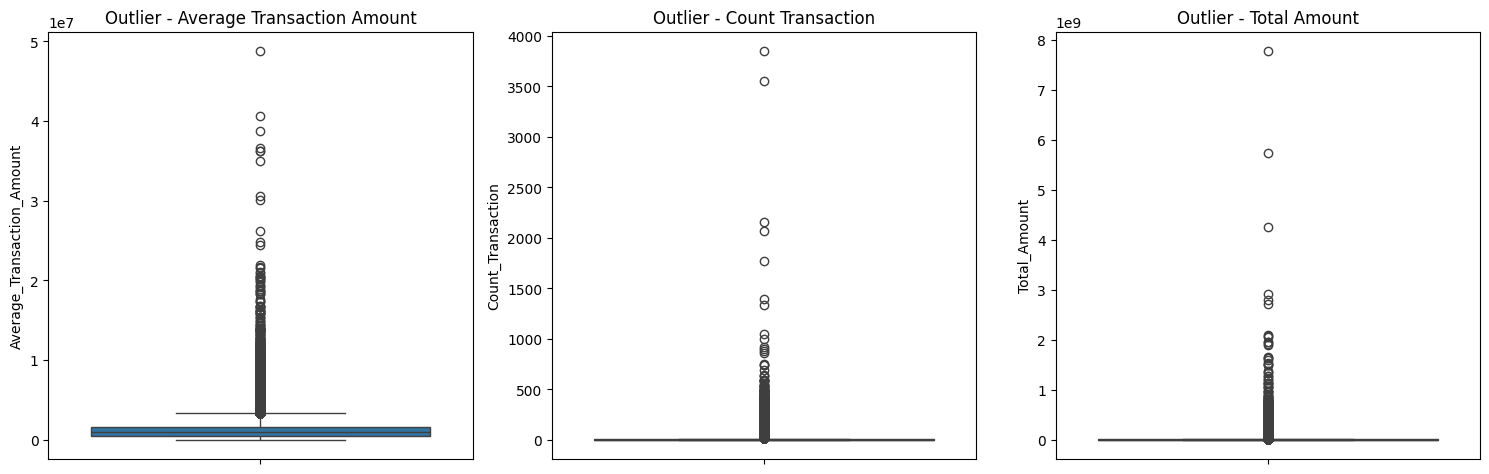

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# Boxplot Average_Transaction_Amount
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Average_Transaction_Amount'])
plt.title('Outlier - Average Transaction Amount')

# Boxplot Count_Transaction
plt.subplot(1, 3, 2)
sns.boxplot(y=df['Count_Transaction'])
plt.title('Outlier - Count Transaction')

# Boxplot Total_Amount
plt.subplot(1, 3, 3)
sns.boxplot(y=df['Total_Amount'])
plt.title('Outlier - Total Amount')

plt.tight_layout()
plt.show()


**Menghitung Jumlah Pelanggan Churn dan Tidak Churn (Calculating the Number of Churned and Retained Customers)**

In [43]:
is_churn=df['is_churn'].value_counts()
print(is_churn)

is_churn
True     66569
False    33431
Name: count, dtype: Int64


**Proporsi Jumlah Pelanggan Churn dan Tidak Churn (Proportion of Churned and Retained Customers)**

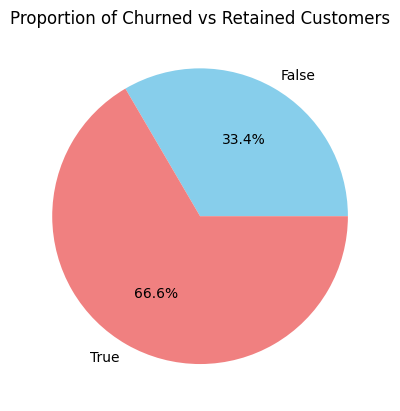

In [44]:
import matplotlib.pyplot as plt

df['is_churn'].value_counts().sort_index().plot(kind='pie', labels=['False', 'True'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Churned vs Retained Customers')
plt.ylabel('')
plt.show()

**Proporsi Churned Customer untuk Setiap Produk (Proportion of Churn by Product)**

<Figure size 640x480 with 0 Axes>

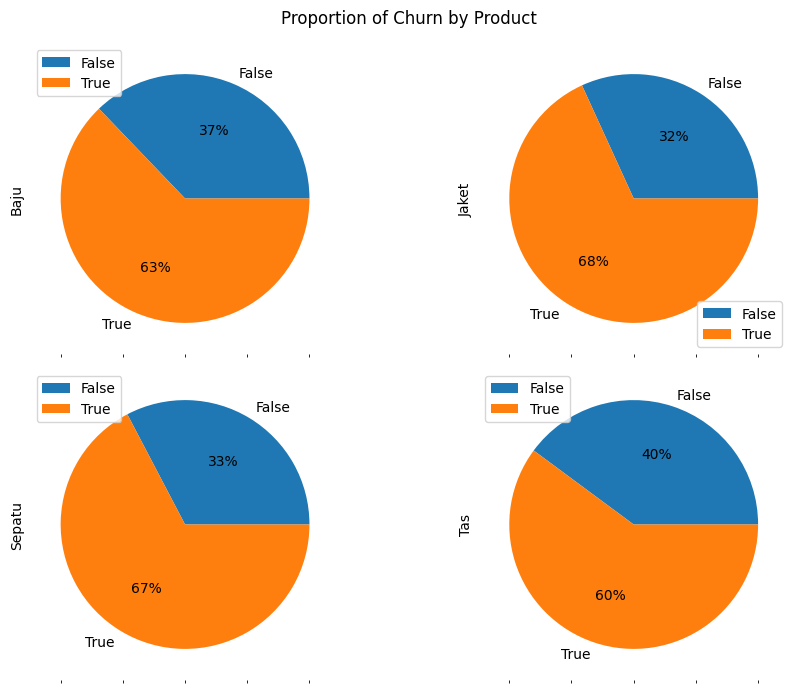

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
# Melakukan pivot data dengan pivot_table
df_piv = df.pivot_table(index='is_churn',
                        columns='Product',
                        values='Customer_ID',
                        aggfunc='count',
                        fill_value=0)

# Mendapatkan Proportion Churn by Product
plot_product = df_piv.count().sort_values(ascending=False).head(5).index

# Mengeplot Pie Chart
df_piv = df_piv.reindex(columns=plot_product)
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion of Churn by Product')
plt.tight_layout()
plt.show()

**Perolehan Pelanggan Baru Tiap Tahun (Customer Acquisition by Year)**

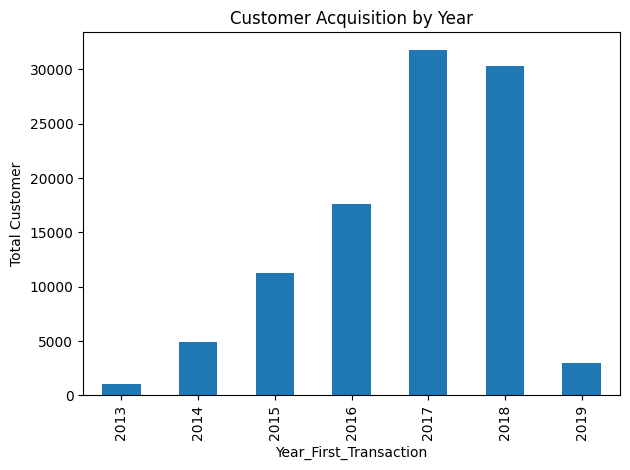

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Membuat plot Customer Acquisition by Year
df_year = df.groupby('Year_First_Transaction')['Customer_ID'].count()

df_year.plot(
    x='Year_First_Transaction',
    y='Customer_ID',
    kind='bar',
    title='Customer Acquisition by Year'
)

plt.xlabel('Year_First_Transaction')
plt.ylabel('Total Customer')
plt.tight_layout()
plt.show()

**Distribusi Kategorisasi Count Transaction (Customer Distribution by Count Transaction Group)**

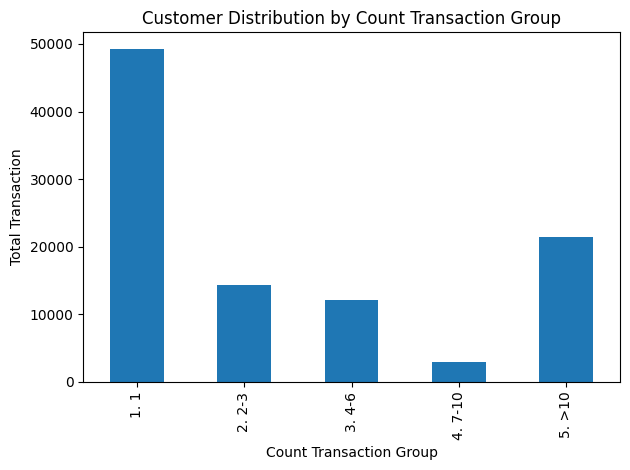

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
# Kategorisasi jumlah transaksi
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1. 1'

    elif (row['Count_Transaction'] >1 and row['Count_Transaction']<= 3):
        val ='2. 2-3'

    elif (row['Count_Transaction']> 3 and row['Count_Transaction']<=6):
        val ='3. 4-6'

    elif (row['Count_Transaction']>6 and row['Count_Transaction']<=10):
        val ='4. 7-10'
    else:
        val ='5. >10'
    return val

# Tambahkan kolom baru
df['Count_Transaction_Group'] = df.apply(func, axis=1)

df_year = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()

df_year.plot(x='Count_Transaction_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaction Group')
plt.xlabel('Count Transaction Group')
plt.ylabel('Total Transaction')
plt.tight_layout()
plt.show()


**Distribusi Kategorisasi Average Transaction Amount (Customer Distribution by Average Transaction Amount Group)**

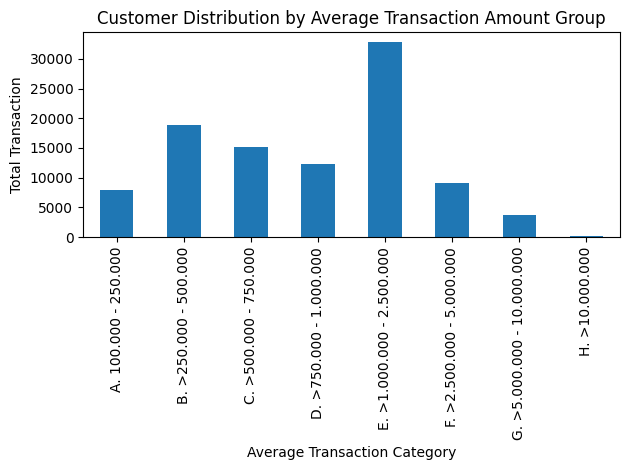

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
# Kategorisasi rata-rata besar transaksi
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <= 250000):
        val = 'A. 100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <= 500000):
        val = 'B. >250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 750000):
        val = 'C. >500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <= 1000000):
        val = 'D. >750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val = 'E. >1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val = 'F. >2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val = 'G. >5.000.000 - 10.000.000'
    else:
        val = 'H. >10.000.000'
    return val

# Tambahkan kolom baru
df['Average_Transaction_Amount_Group'] = df.apply(f, axis=1)

df_year = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()

df_year.plot(x='Average_Transaction_Amount_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Average Transaction Amount Group')
plt.xlabel('Average Transaction Category')
plt.ylabel('Total Transaction')
plt.tight_layout()
plt.show()

**Feature Columns & Target**

In [49]:
import pandas as pd

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Feature column: Year_Diff
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']

# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

# Features variable
X = df[feature_columns]

# Target variable
y = df['is_churn']


**Split X dan y Ke Dalam Bagian Training dan Testing (Split X and y into Training and Testing)**

In [50]:
import pandas as pd

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Feature column: Year_Diff
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']

# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

# Features variable
X = df[feature_columns]

# Target variable
y = df['is_churn']

# Split X and y into Training and Testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**Train, Predict & Evaluate**

In [51]:
import pandas as pd

# Mengonversi format dbdate ke format datetime
df['First_Transaction_Date'] = pd.to_datetime(df['First_Transaction_Date'])
df['Last_Transaction_Date'] = pd.to_datetime(df['Last_Transaction_Date'])

# Mengekstrak tahun dari datetime
df['Year_First_Transaction'] = df['First_Transaction_Date'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction_Date'].dt.year

# Feature column: Year_Diff
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']

# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

# Features variable
X = df[feature_columns]

# Target variable
y = df['is_churn']

# Split X and y into Training and Testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Train, Predict & Evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Inisiasi model logreg
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

# Predict model
y_pred = logreg.predict(X_test)

# Evaluasi model menggunakan confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[ 3390  4843]
 [ 1021 15746]]


**Visualisasi Confusion Matrix**

<Figure size 640x480 with 0 Axes>

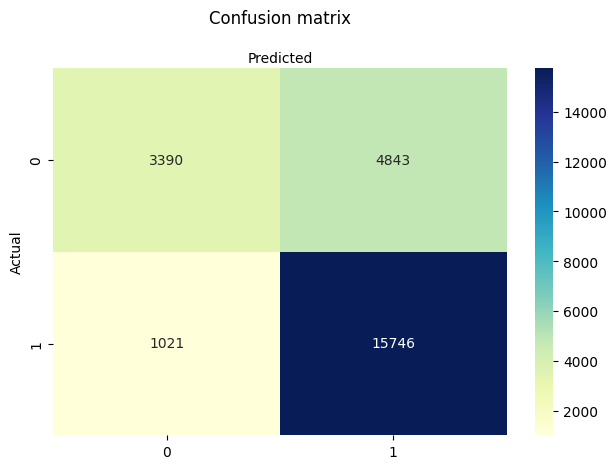

In [52]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# name  of classes
class_names = [0, 1]
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')

ax.xaxis.set_label_position('top')
plt.title('Confusion matrix', y=1.1)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

**Accuracy, Precision, & Recall**

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Menghitung Accuracy, Precision, dan Recall
print('Accuracy :', accuracy_score(y_test, y_pred))

print('Precision:', precision_score(y_test, y_pred, average='micro'))

print('Recall   :', recall_score(y_test, y_pred, average='micro'))

Accuracy : 0.76544
Precision: 0.76544
Recall   : 0.76544
